<a href="https://colab.research.google.com/github/rmalhotra2192/transformers-pytorch-implementation-explained/blob/main/TransformersImplementation_PyTorchTutorial_EXPLAINED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What's this notebook?

This notebook is my attempt in order to understand the **implementation of Transformers ( Based on the famous paper "[Attention is all you need](https://arxiv.org/abs/1706.03762)") from scratch in PyTorch**. I have added extensive comments in order to decode most of the code and relate what it's doing relative to the architecture that's explained in the paper and how it's being trained.


In [1]:
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_lg
!python -m spacy download de_core_news_lg
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 39.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.4
    Uninstalling spacy-3.4.4:
      Successfully uninstalled spacy-3.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.5.1 which is incompatible.
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-10 21:56:01.106927: I tensorflow/core/platform/cpu_feature_guard.cc:193

## Brief Explaination about Self Attention and Multi Head Attention.
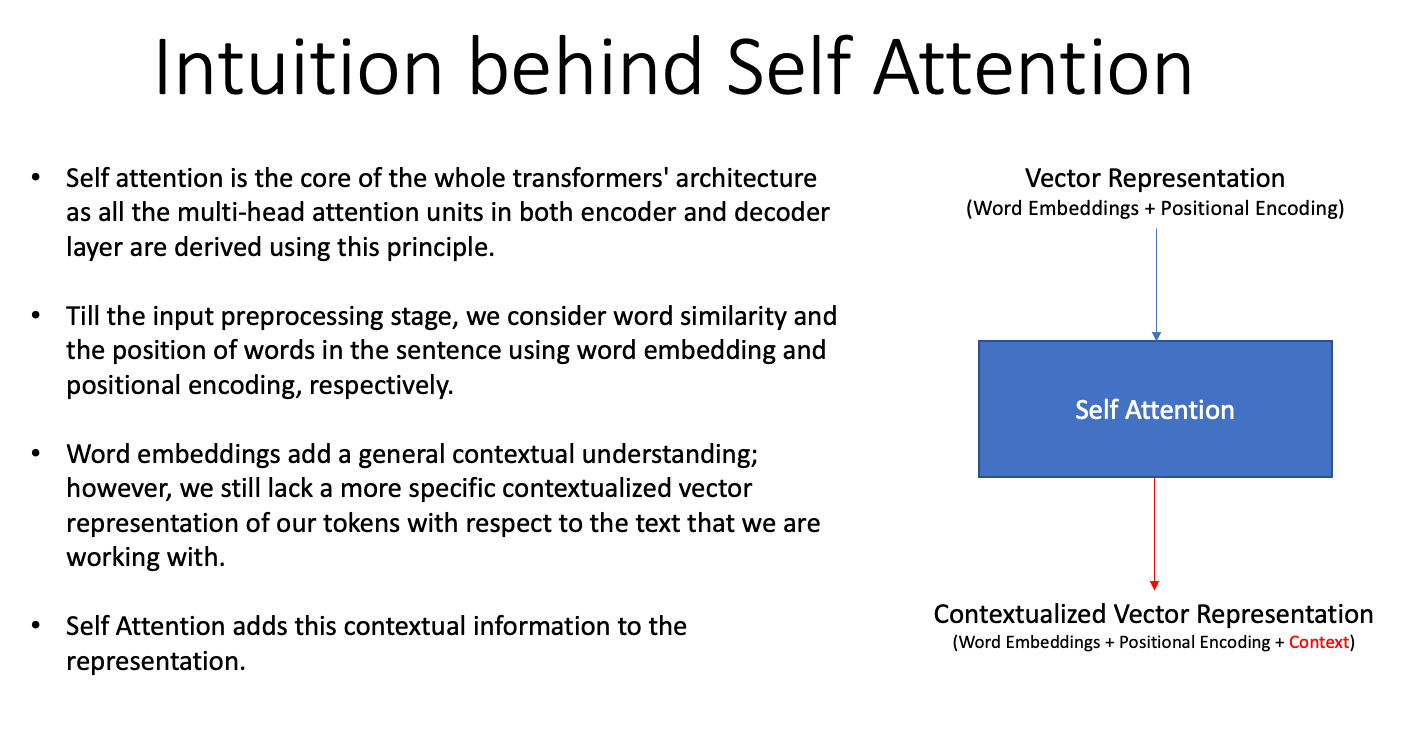

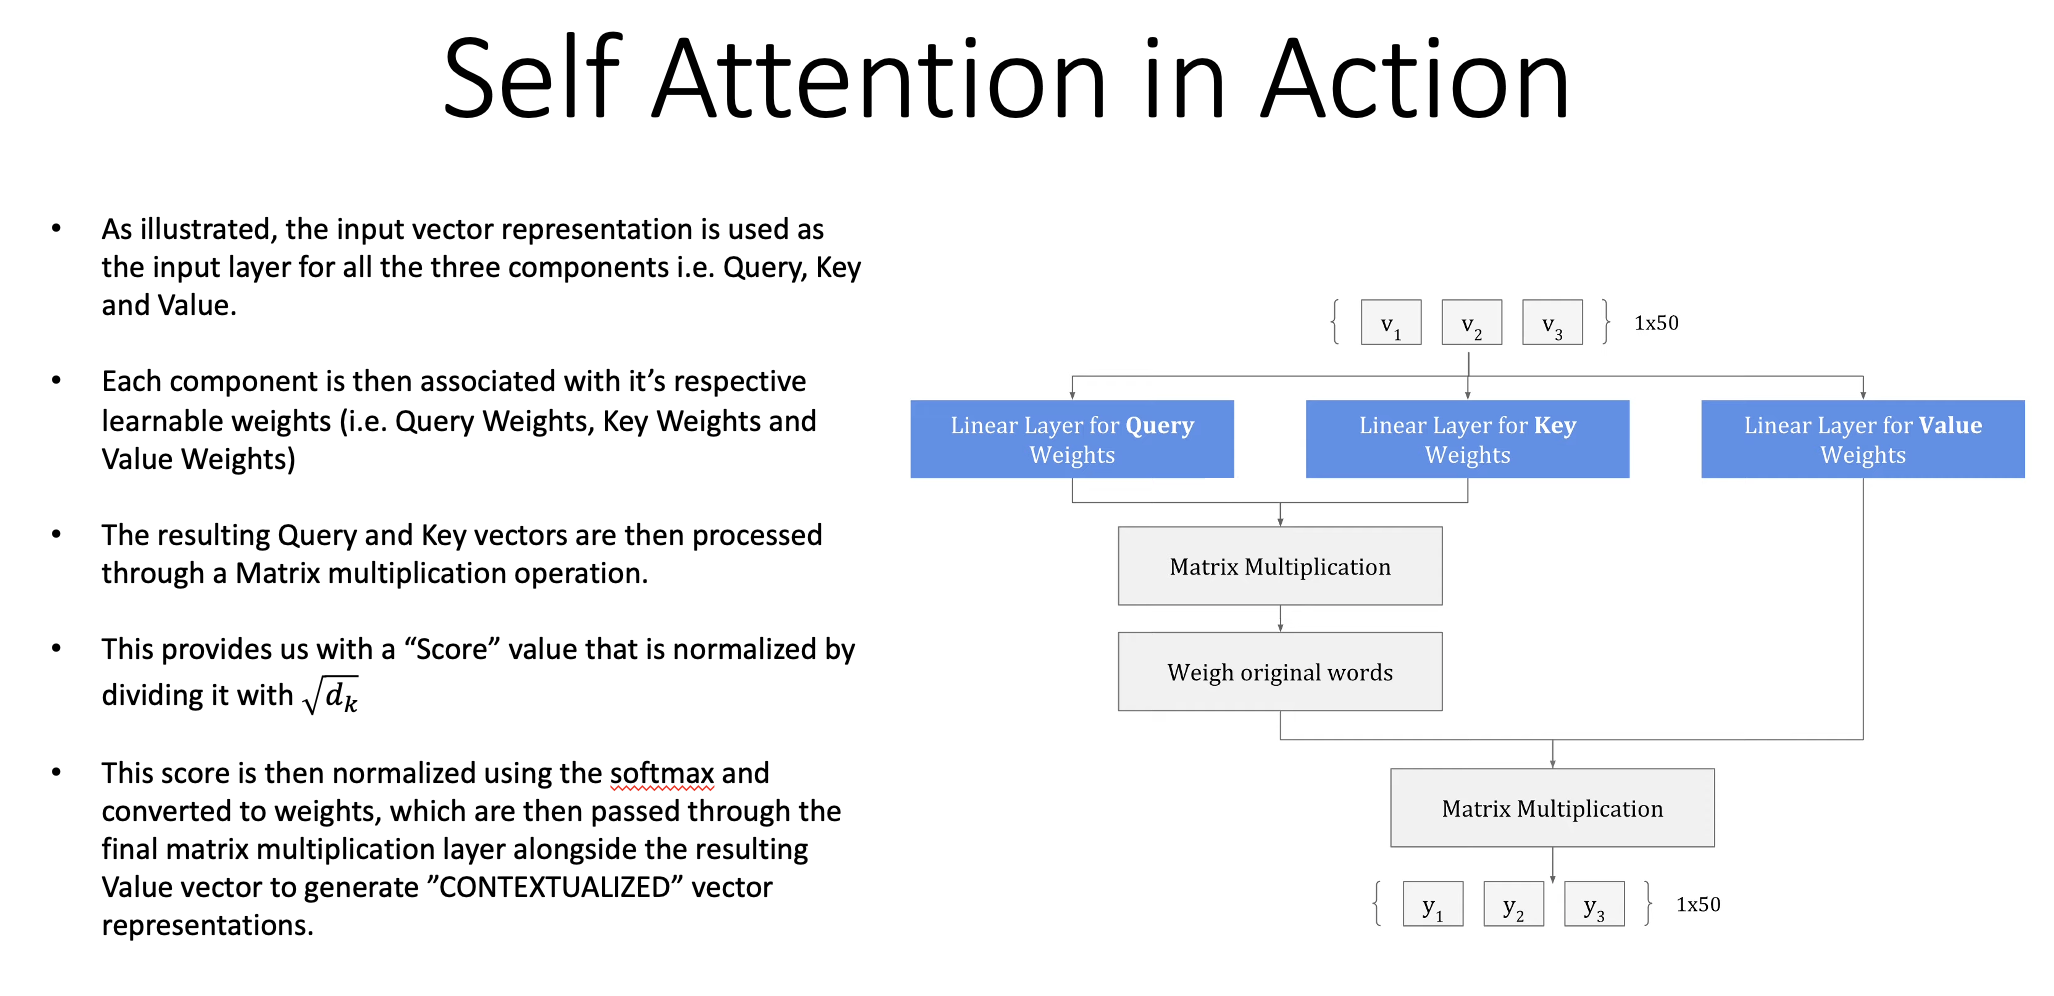

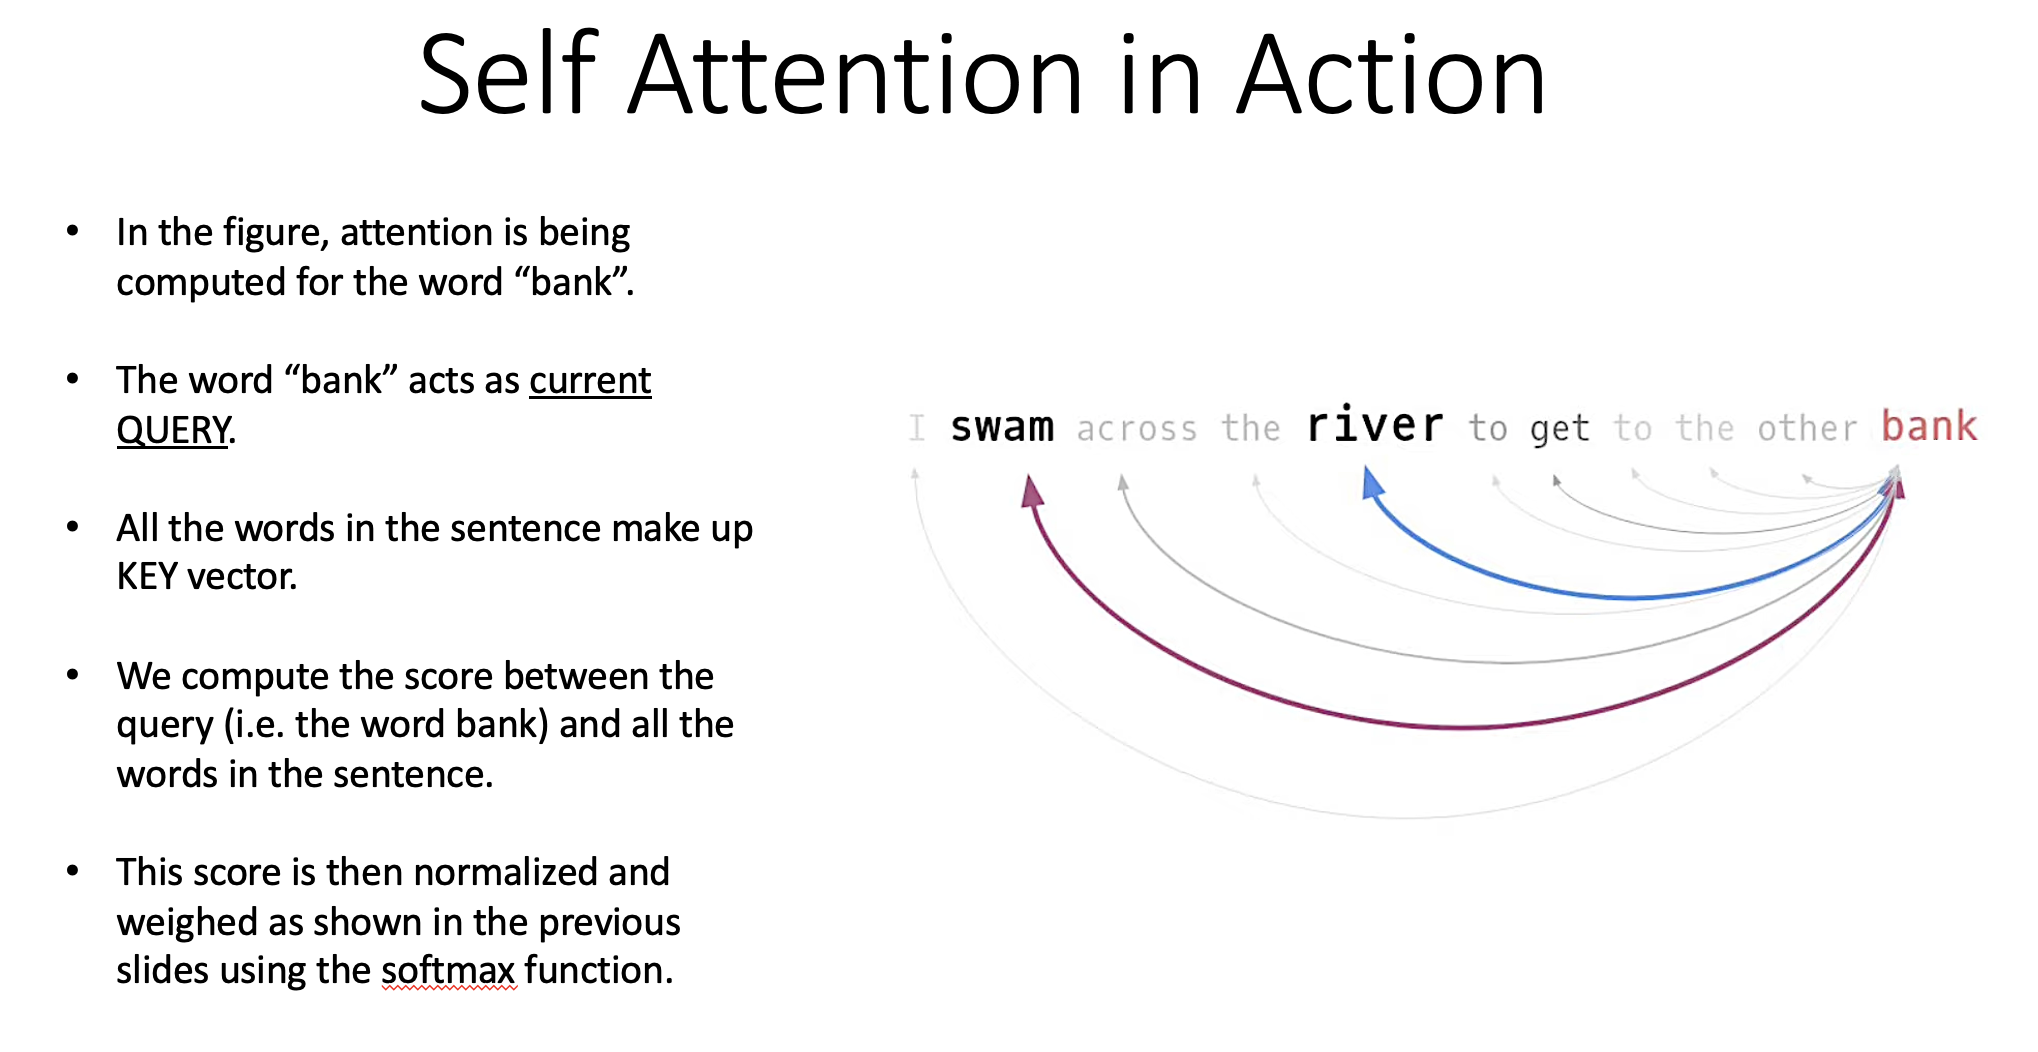

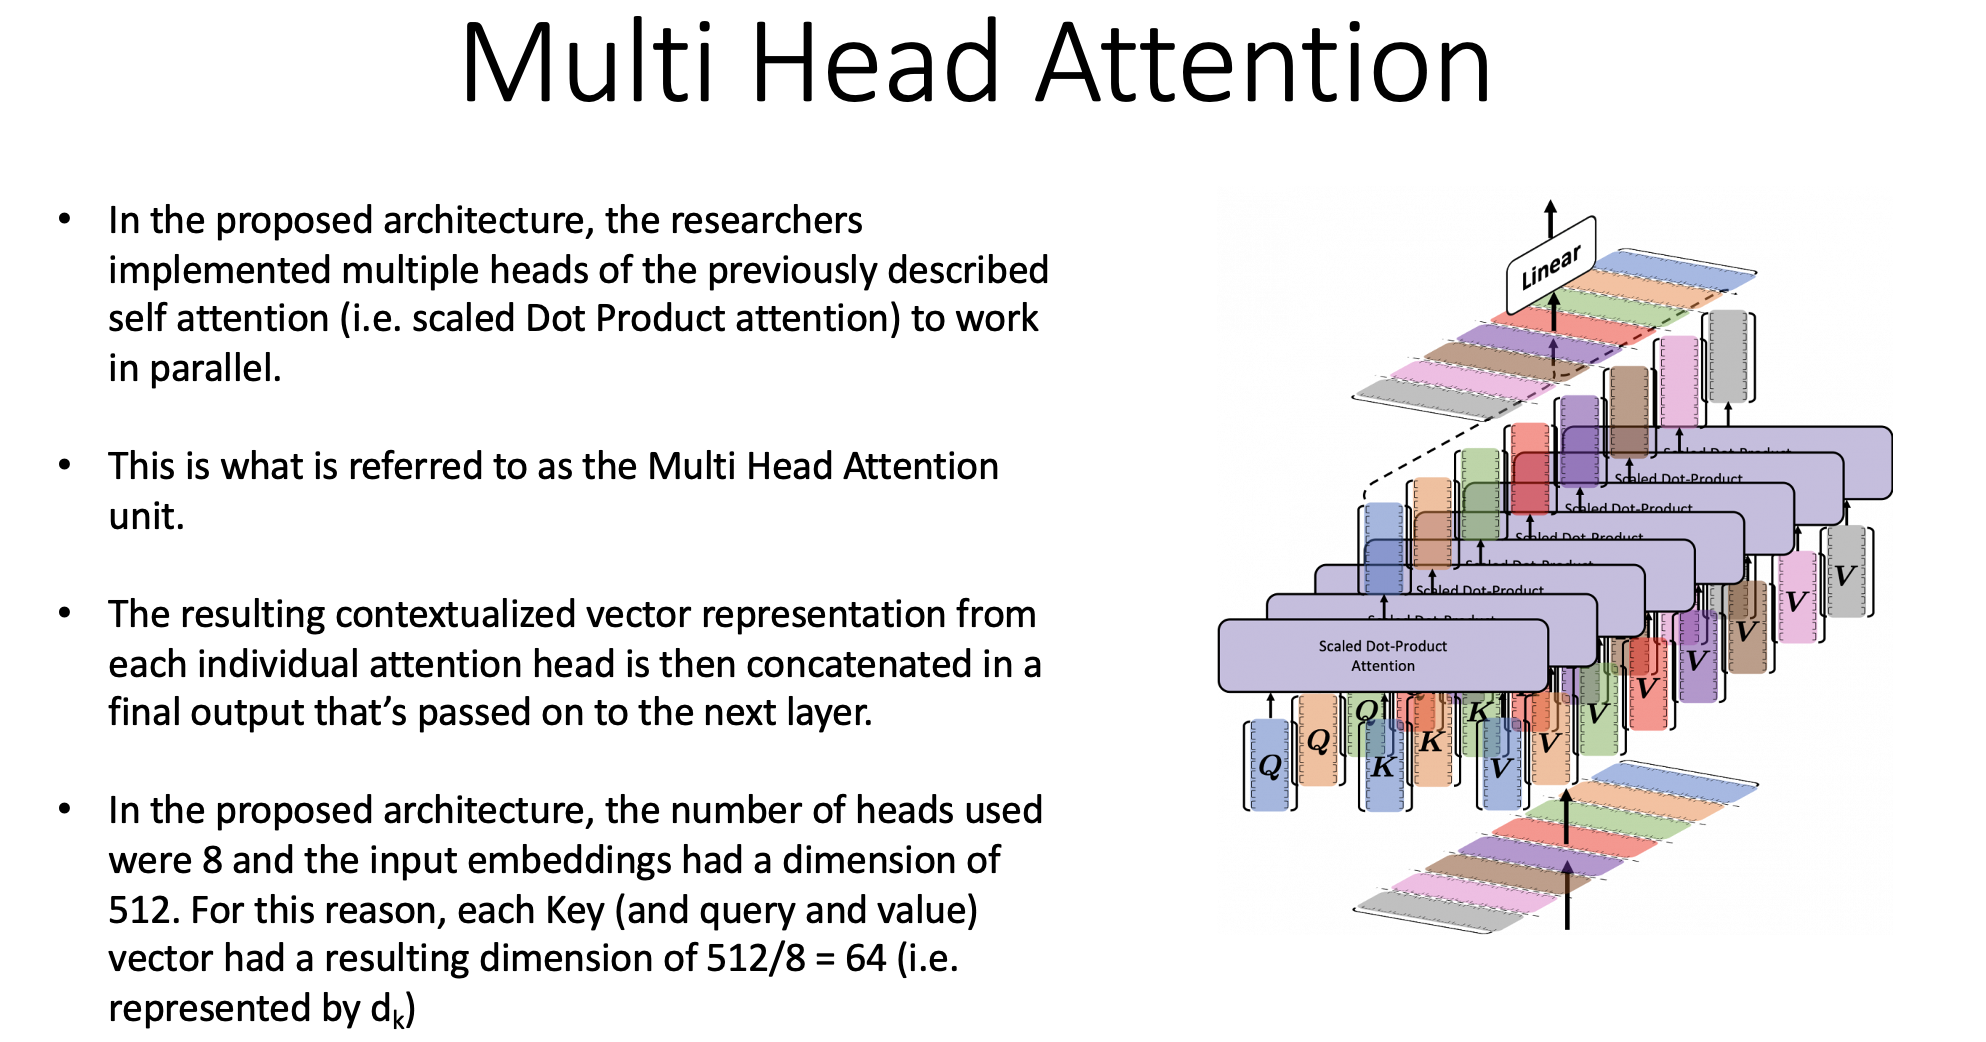

# Data Description

Size: Multi30k contains 31,014 images and 290,000 captions.

Source: The images in Multi30k were taken from the Flickr30k dataset, but were selected based on specific criteria such as diversity in terms of objects, scenes, and viewpoints.

Captions: The captions in Multi30k were written by professional translators in English, German, French, and Czech.

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List


# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

# Source Language = DE ("GERMAN")
SRC_LANGUAGE = 'de'

# TARGET Language = EN ("ENGLISH")
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

# Generate tokenizer function for a string sentence.
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_lg')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_lg')


# helper generator function to yield list of tokens for each sentence
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices and making sure the tokens are in order of 
# their indices to properly insert them in vocab
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# For both the source and target language generate the vocabulary index mapping based on vocab frequency.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
import math
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Transformer

# Set device based on system runtime configuration.
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Token Embeddings

In [ ]:
# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        
        # Word Embedding Initialization - Using PyTorch Embedding layer.
        self.embedding = nn.Embedding(vocab_size, emb_size)

        # Setting embedding dimension size 
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        # NOTE: scaling factor is used to prevent the variance of the token embeddings from becoming too small as the
        # dimensionality of the embeddings increases.
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

## Positional Embeddings 

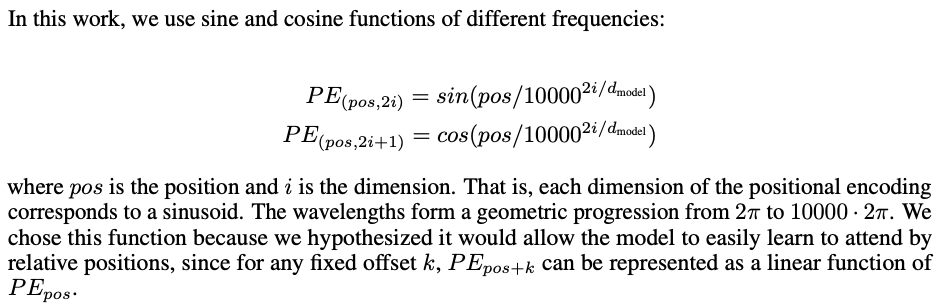

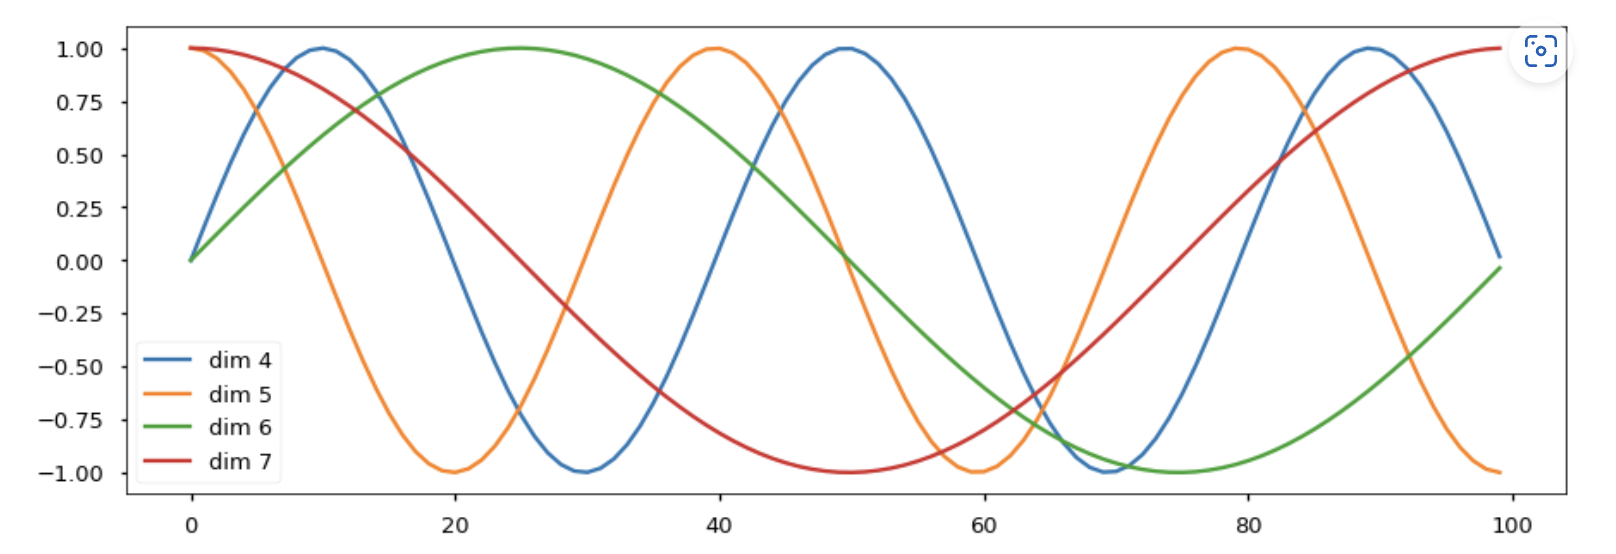

In [ ]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    # takes the input token embeddings and adds the positional encoding to it using element-wise addition.
    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

## Transformer Network

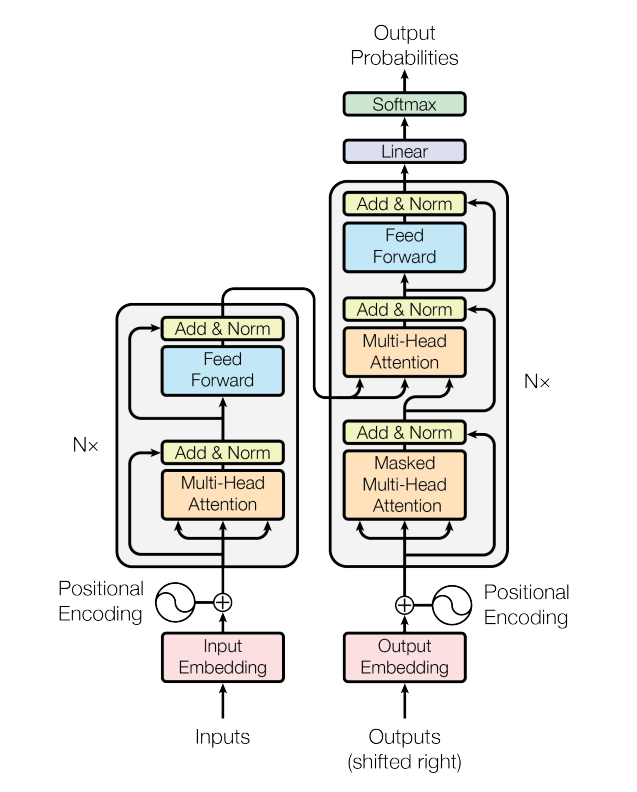

In [ ]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()

        # creating a transformer object with relevant parameters.
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        
        # linear layer at the end of final output sequence (takes transformers output as input)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

        # source and target language token embedding objects to transform source and target sequences into embeddings
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)

        # positional encoding object to add position encodings to retain token order in input and output sequences
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    # implement forward method to compute positional encodings and transformer outputs 
    # that can be passed to the linear layer stored in the generator object mentioned above.
    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):

        # computing positional encoding for token embeddings of source sequence
        src_emb = self.positional_encoding(self.src_tok_emb(src))

        # computing positional encoding for token embeddings of target sequence
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        # computing transformer output
        # src_padding_mask is used to mask out padding tokens during computation of encoder output
        outs = self.transformer(src_emb, 
                                tgt_emb, 
                                src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        
        # returning the output from the linear layer
        return self.generator(outs)

    # implement encode method to return one single encoding layer.
    # src is the source sequence
    # src_mask is used to mask out padding tokens (during self attention)
    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    # implement decode method to return one single decoding layer.
    # tgt is the target sequence
    # memory is the encoded source sequence i.e. set of context vectors that summarize the input sequence
    # tgt_mask square mask to ensure decoder only attends to already generated tokens.
    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
# implementing triangular mask to ensure decoder units can only attend to previous positions and not future positions.
def generate_square_subsequent_mask(sz):
    # creates all ones square tensor with sz size and make below diognal values zero. then make upper diagonal matrix
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
# setting the seed for reproducibility
torch.manual_seed(0)

# MODEL HYPERPARAMETERS
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE]) # Source Language Vocabulary Size
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE]) # Target Language Vocabulary Size
EMB_SIZE = 512 # Token Embedding Size
NHEAD = 4 # Number of Heads in the Multi Head Attention Units
FFN_HID_DIM = 512 # 
BATCH_SIZE = 32 # Batch Size
NUM_ENCODER_LAYERS = 4 # Number of Encoder Layers
NUM_DECODER_LAYERS = 4 # Number of Decoder Layers

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

# initialize parameters using xavier initialization method 
# (xavier initialization method is used so that variance 
# of inputs and outputs of each layers are equal.)
# More about initalize parameters 
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# moving transformer to the active runtime device
transformer = transformer.to(DEVICE)

# initializes the loss function used for training the model. 
# cross entropy loss function is used.
# ignore_index ignores the index of the padding token when computing the loss.
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

## Optimization

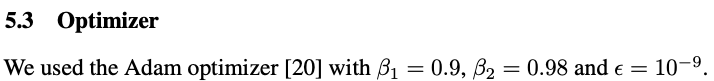

In [ ]:
# initializes the adam optimizer used for training the model.
# lr is learning rate
# betas and eps refer to adam optimizer hyperparameters.
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
# Get the number of trainable parameters in the transformer.
trainable_params = sum(
	p.numel() for p in transformer.parameters() if p.requires_grad
)
print("Trainable Parameters: {:,}".format(trainable_params))

Trainable Parameters: 37,778,005


In [ ]:
# add padding to convert sequences with variable length to fixed length
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations and apply multiple transformation to text input sequentially.
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# helper function to add bos/eos and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# dictionary of transformation fucntion for both source and target language.
# transformations include converting sequence to tokens which are then numericalized using vocab_transform object from above code
# which then is tranformed to a tensor after adding bos and eos.
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
# create data loaders used to iterate over batches of data during training and evaluation.
from torch.utils.data import DataLoader


def train_epoch(model, optimizer):
    # set the model to training mode
    model.train()


    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)


    for src, tgt in train_dataloader:
        # moves src and tgt tensor to runtime device
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)


        tgt_input = tgt[:-1, :]

        # create all the relevant masks for source and target tensors
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        # forward pass
        # unnormalized output of transformer model before applying softmax
        # represents score to each possible target token at each position
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        # reset the gradient values to only account for the new gradients computed for this batch.
        optimizer.zero_grad()

        # loss_fn to compute the loss between logits and true target sequence
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        # compute gradients using backpropogation to update model parameters based on the loss.
        loss.backward()

        # update the parameters with requires_grad=True with respect to the loss gradients in order to improve them.
        optimizer.step()

        # adding loss of this batch to total loss of epoch
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 10


for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):

    # move source sequence to runtime device
    src = src.to(DEVICE)

    # move source mask to runtime device
    src_mask = src_mask.to(DEVICE)

    # compute contextual encodings using model encoder layers
    memory = model.encode(src, src_mask)

    # initalize target token tensor
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    

    for i in range(max_len-1):
        # move contextualized encodings from encoder to runtime device
        memory = memory.to(DEVICE)

        # create target mask to only enable decoder to attend to only already generated tokens. 
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
        
        # decode method to generate the logits for each possible target token at each position
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)

        # softmax operation
        prob = model.generator(out[:, -1])

        # get the word having maximum probability
        _, next_word = torch.max(prob, dim=1)
        
        # get the scalar value
        next_word = next_word.item()

        # concatenate next word token index to output sequence
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        
        # breaks the loop when eos token appears
        if next_word == EOS_IDX:
            break
            
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

Epoch: 1, Train loss: 4.163, Val loss: 3.452, Epoch time = 49.068s
Epoch: 2, Train loss: 3.061, Val loss: 2.662, Epoch time = 45.602s
Epoch: 3, Train loss: 2.443, Val loss: 2.313, Epoch time = 45.708s
Epoch: 4, Train loss: 2.081, Val loss: 2.135, Epoch time = 45.426s
Epoch: 5, Train loss: 1.842, Val loss: 2.044, Epoch time = 45.351s
Epoch: 6, Train loss: 1.659, Val loss: 2.002, Epoch time = 45.609s
Epoch: 7, Train loss: 1.517, Val loss: 1.986, Epoch time = 45.705s
Epoch: 8, Train loss: 1.396, Val loss: 1.974, Epoch time = 45.610s
Epoch: 9, Train loss: 1.299, Val loss: 1.977, Epoch time = 45.637s
Epoch: 10, Train loss: 1.208, Val loss: 1.965, Epoch time = 45.367s


In [ ]:
# Google translate - Two children are sitting on a seesaw.
print(translate(transformer, "zwei kinder sitzen auf einer wippe ."))

 Two children are sitting on a wooden table . 


In [ ]:
# Google translate - a worker does something with the street
print(translate(transformer, "ein arbeiter macht etwas mit der strasse"))

 A military worker is doing something to the video game . 


In [ ]:
# Google translate -  a person who paints a picture .
print(translate(transformer, "eine person die ein bild malt ."))

 A military worker is painting a fire hydrant . 


In [ ]:
# Google translate - a man with cleaning tools is dancing on a square .
print(translate(transformer, "ein mann mit reinigungswerkzeug tanzt auf einem platz ."))

 A military man with replica dancing at a target . 


In [ ]:
# Google translate - a child playing on a climbing frame
print(translate(transformer, "ein kind beim spielen auf einem klettergerüst"))

 A child playing a child on a wooden table . 


The original version of the code of this notebook can be referenced from https://bit.ly/421skWZ.

Last Updated: 11th March, 2023